# Table of content

1. [Load and prepare the data](#Load-and-prepare-the-data)
    1. [Configuration](#Configuration)
    1. [Load the csv data files](#Load-the-csv-data-files)
    1. [Clean and reshape the data](#Clean-and-reshape-the-data)
1. [Participant rates](#Participant-rates)
    1. [Easy to understand](#Easy-to-understand)
    1. [Mentally easy to use](#Mentally-easy-to-use)
    1. [Physically easy to use](#Physically-easy-to-use)
    1. [Subjective speed](#Subjective-speed)
    1. [Subjective performance](#Subjective-performance)
    1. [Frustration](#Frustration)
1. [Participant trials](#Participant-trials)
    1. [Distributions](#Distributions)
    1. [Completion time](#Completion-time)
    1. [Errors](#Errors)
1. [Bonus](#Bonus)
    1. [Grid configuration](#Grid-configuration)

# Load and prepare the data

## Configuration

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats

from ast import literal_eval
from os import listdir
from os.path import join

C:\Users\Erwan\Miniconda\envs\master-thesis\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

sns.set_style('whitegrid')
sns.set_context('notebook')

## Load the csv data files

The participants information are in `participants`, all the trials in `trials`, the participant rates in `rates` and the detailled mesures of the trials in `trial_details`.

In [42]:
participants = pd.read_csv('participants.csv')
trials = pd.read_csv('participant_trials.csv')
rates = pd.read_csv('participant_rates.csv')

In [4]:
# Detailled trials are long to load, keep commented if unused

#trial_details = []
#for file in listdir('.'):
#    if file.endswith('details.csv'): # The trial files end with *-details.csv
#        details.append(pd.read_csv(file))
#trial_details = pd.concat(details, ignore_index=True)

## Clean and reshape the data

Creates `participants_ivs`, `trials_ivs` independent variables lists, and `participants_dps`, `trials_dps` dependent variables list from participants and trials. Used to set up categories on some variables and to set a displaying name on all of them.

In [4]:
# Participants IVs
participants_iv_labels = participants.columns
participants_iv_names = ['Participant Id', 'Sex', 'Has Glasses', 'Has Contact Lenses', 'Is Color Blind',\
                         'Age Class', 'Dominant Hand', 'Hand Used for Mouse', 'Activity', 'Computer Hours per Day',\
                         '3D Softwares Used', 'HMD Used', 'Known Interactions Techniques on HMD']
participants_ivs = pd.DataFrame(data=[participants_iv_labels, participants_iv_names],\
                                columns=participants_iv_labels, index=['label', 'name'])

In [7]:
# Trials IVs
trials_iv_labels = ['technique', 'text_size', 'distance', 'ordering', 'input', 'output']
trials_iv_names = ['Technique', 'Text Size', 'Distance', 'Ordering', 'Technique Input', 'Technique Output']
trials_ivs = pd.DataFrame(columns=trials_iv_labels, index=['label', 'name', 'categorical', 'palette'])

for i in range(len(trials_ivs.columns)):
    iv_label = trials_ivs.columns[i]
    iv_id = iv_label + '_id'
    iv_categories = trials.drop_duplicates(iv_id).loc[:, [iv_id, iv_label]].sort_values([iv_id])
    
    trials[iv_id] = trials[iv_id].astype(CategoricalDtype(categories=iv_categories[iv_id], ordered=True))
    trials[iv_label] = trials[iv_label].astype(CategoricalDtype(categories=iv_categories[iv_label], ordered=True))
    trials_ivs[iv_label] = [trials_iv_labels[i],\
                            trials_iv_names[i],\
                            pd.Categorical(iv_categories[iv_label], iv_categories[iv_label], ordered=True),\
                            'Set2'] # Default palette

trials_ivs.at['palette', 'text_size'] = sns.light_palette(sns.color_palette('Set2')[5], 3)[1:3] # Yellow paired colors
trials_ivs.at['palette', 'distance'] = sns.light_palette(sns.color_palette('Set2', 7)[6], 3)[1:3] # Brown paired colors
trials_ivs.at['palette', 'ordering'] = sns.light_palette(sns.color_palette('Set2')[4], 4)[1:4] # Green trio colors                          

In [14]:
# Shortcut to access the different trials IVs' categories
categories = pd.Series([trials_ivs[label]['categorical'].categories for label in trials_ivs.columns], index=trials_ivs.columns)

In [33]:
# Sets up dependent variables lists
rates_dv_labels = rates.loc[:, 'easy_understand':'frustration'].columns
rates_dv_names = ['Easy to Understand', 'Mentally Easy to Use', 'Physically Easy to Use',\
                         'Subjective Speed', 'Subjective Performance', 'Frustration']
rates_dv_scale = pd.Categorical(list(range(1,6)), list(range(1,6)), ordered=True)
rates_dv_palette = sns.color_palette('RdYlBu', 5)
rates_dvs = pd.DataFrame(data=[rates_dv_labels,\
                               rates_dv_names,\
                               [rates_dv_scale] * len(rates_dv_labels),\
                               [rates_dv_palette] * len(rates_dv_labels)],\
                         columns=rates_dv_labels, index=['label', 'name', 'scale', 'palette'])

rates_dvs['preference'] = ['preference',\
                           'Preference',\
                           pd.Categorical(list(range(1,4)), list(range(1,4)), ordered=True),\
                           [sns.color_palette('RdYlBu', 5)[i] for i in range(4,-1,-2)]] # Last and first color of the palette

trials_dv_labels = trials.loc[:, 'total_time':'signed_head_phone_distance'].columns
trials_dv_names = ['Completion Time (s)', 'Selections', 'Total Time Selecting (s)', 'Total Distance Selecting (m)',\
                   'Total Distance Projected on Grid Selecting (m)', 'Deselections', 'Errors', 'Items Classified',\
                   'Number of Pans', 'Total Time Panning (s)', 'Total Distance Panning (m)',\
                   'Total Distance Projected on Grid Panning (m)', 'Number of Zooms', 'Total Time Zooming (s)',\
                   'Total Distance Zooming (m)', 'Total Distance Projected on Grid Zooming (m)',\
                   'Total Head Phone Distance (m)', 'Signed Total Head Phone Distance (m)']
trials_dvs = pd.DataFrame(data=[trials_dv_labels, trials_dv_names],\
                          columns=trials_dv_labels, index=['label', 'name'])

Clean the data:

In [43]:
# Set the participant_id column as the index in participants
participants.set_index('participant_id', inplace=True)

In [44]:
# Some participants are non valid or don't have complete mesures
non_valid_participants = [0]
participants = participants[~participants.index.isin(non_valid_participants)]
rates = rates[~rates['participant_id'].isin(non_valid_participants)]

incomplete_trials_participant_ids = [0, 4]
trials = trials[~trials['participant_id'].isin(incomplete_trials_participant_ids)].reset_index(drop=True)

In [45]:
# Some participants have wrong head phone mesures
for head_distance_column in ['absolute_head_phone_distance', 'signed_head_phone_distance']:
    trials.loc[trials[head_distance_column] == 0, head_distance_column] = np.nan

In [46]:
# Copy ordering column from rates to participants
participants['ordering'] = rates.groupby('participant_id')['ordering'].first()
participants['ordering'] = participants['ordering'].astype(trials_ivs['ordering']['categorical'])

# Set categoricals to rates IVs
for iv_label in ['ordering', 'technique']:
    rates[iv_label] = rates[iv_label].astype(trials_ivs[iv_label]['categorical'])

In [48]:
# Eval the arrays in some dvs
def eval_if_str(data):
    return literal_eval(data) if isinstance(data, str) else data

trials['grid_config'] = trials['grid_config'].apply(eval_if_str)

# Participant rates

Vizualise, for each 5-points Likert question (5 is the best, 1 is the worst) and for each technique, all the participant rates first, the the mean rate, finally the mean rate dependending of the participant ordering.

Participants tested the techniques in the order:

- (*PhoneOnly*, *PhoneInArOut*, *LeapInArOut*) with ordering 0,
- (*PhoneInArOut*, *LeapInArOut*, *PhoneOnly*) with ordering 1,
- (*LeapInArOut*, *PhoneOnly*, *PhoneInArOut*) with ordering 2.

In [52]:
def get_rates_count(iv_labels, dv_label):
    rates_counts = rates.groupby(iv_labels + [dv_label]).size() # Gets the counts
    
    ivs = [trials_ivs[iv_label]['categorical'] for iv_label in iv_labels]
    rates_counts_index = pd.MultiIndex.from_product(ivs + [rates_dvs.at['scale', dv_label]],\
                                                    names=iv_labels + ['rate'])
    zero_rates_counts = pd.Series(0, index=rates_counts_index)
    
    rates_counts = pd.concat([rates_counts, zero_rates_counts]) # Merge counts with the default counts
    rates_counts = rates_counts[~rates_counts.index.duplicated(keep='first')] # Keeps the counts or the default counts
    rates_counts.sort_index(inplace=True)
    rates_counts.index = rates_counts_index # Restore the index
    return rates_counts

In [54]:
def cumulated_barplot(data, palette, **args):
    for row_index, row in data.iloc[::-1].iterrows():
        sns.barplot(x=row, y=row.index, label=row_index, color=palette[row_index-1], orient='h', **args)

In [59]:
def plot_rates(dv_label):
    iv_technique, iv_ordering = trials_ivs['technique'], trials_ivs['ordering']
    dv = rates_dvs[dv_label]
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    cumulated_rates_count = get_rates_count(['technique'], dv_label).unstack(level=0).cumsum()
    cumulated_barplot(cumulated_rates_count, palette=dv['palette'], ax=axs[0])
    axs[0].set(xlabel='Number of participants', ylabel=iv_technique['name'])
    axs[0].legend(title='Rates', frameon=True)
    
    sns.barplot(x=iv_technique['label'], y=dv['label'], data=rates, palette=iv_technique['palette'], ax=axs[1])
    axs[1].set(xlabel=iv_technique['name'], ylabel=dv['name'], ylim=(0, dv['scale'][-1]))
    
    sns.barplot(x=iv_ordering['label'], y=dv['label'], hue=iv_technique['label'], data=rates, palette=iv_technique['palette'], ax=axs[2])
    axs[2].set(xlabel=iv_ordering['name'], ylabel=dv['name'], ylim=(0, dv['scale'][-1]))
    axs[2].legend(title=iv_technique['name'], frameon=True)

## Easy to understand

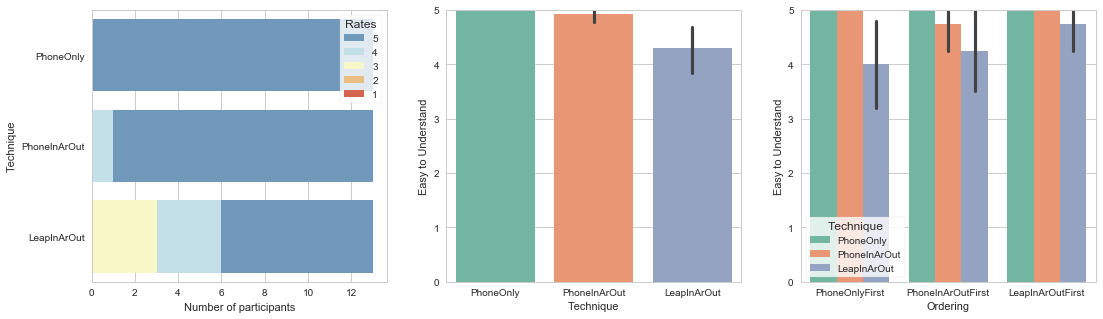

In [61]:
plot_rates('easy_understand')

*LeapInArOut* is harder to understand than the others techniques, particularly when it's the last technique tested (ordering 0). I hypothesised the same, because it presents new interaction techniques.

## Mentally easy to use

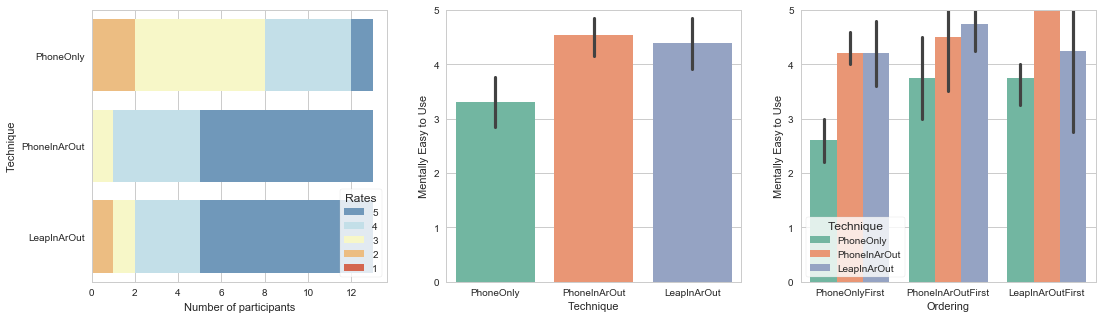

In [62]:
plot_rates('mentally_easy_use')

*PhoneOnly* is mentally more difficult to use mentally than the other techniques, particularly when it's the first technique tested (ordering 0). I hypothesised *PhoneInArOut* to be the easiest to use mentally as the screen is larger and the interaction techniques used are already mastered by the participants.

## Physically easy to use

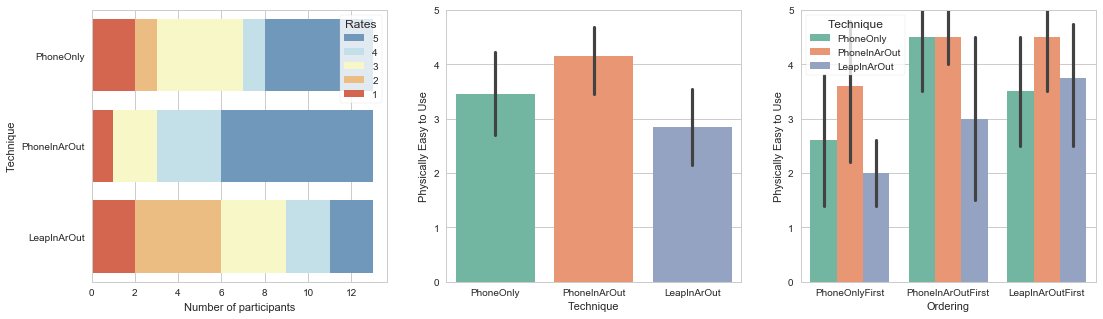

In [63]:
plot_rates('physically_easy_use')

TECHNIQUE has no effect on PHYSICALLY_EASY_USE. I hypothesised *PhoneInArOut* to be the less tiring. But some participants told me that even if the screen is bigger, it demands to pan very often to reach a target (an item or a grid's cell). The same applies to *PhoneOnly*. *LeapInArOut* is also tiring, because the mid-air interactions cause arm fatigue. However, some participants liked the ability to reach directly a target outside the phone's screen.

## Subjective speed

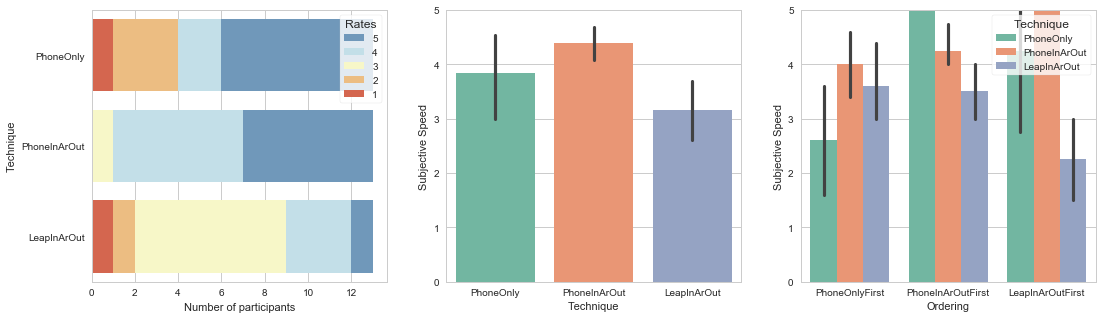

In [64]:
plot_rates('could_go_fast')

## Subjective performance

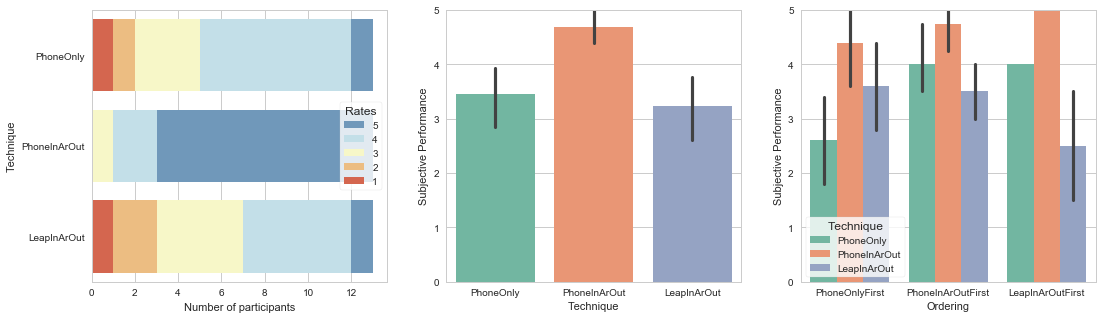

In [65]:
plot_rates('subjective_performance')

## Frustration

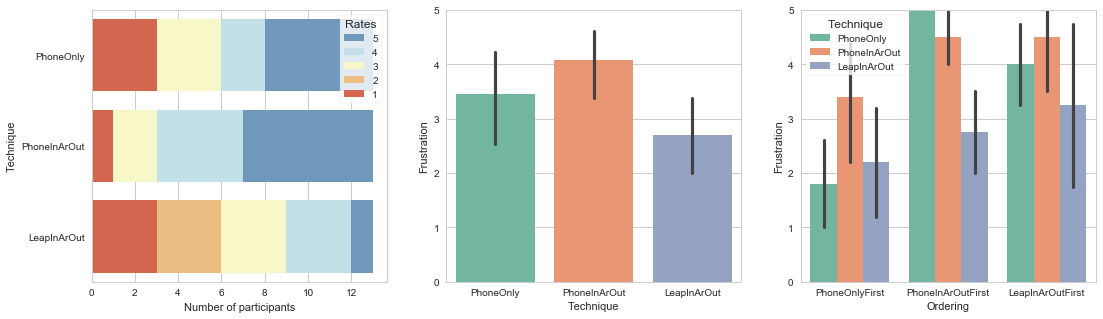

In [66]:
plot_rates('frustration')

## Preference

Visualize the participants preferences (1 is better, 3 is worst):

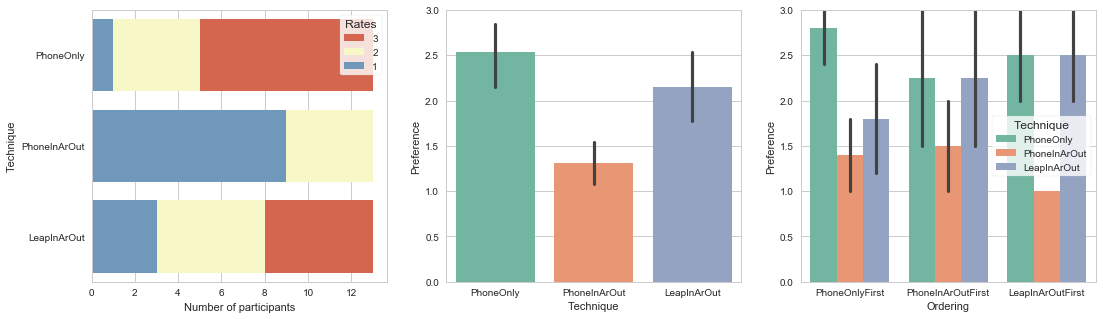

In [67]:
plot_rates('preference')

# Participants trials

In [68]:
def plot_trials(iv_labels_list, dv_label):
    dv = trials_dvs[dv_label]
    
    nrows, ncols = ((len(iv_labels_list)-1)//3)+1, min(3, len(iv_labels_list))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey='row', figsize=(6 * ncols,5))
    
    if nrows == 1 and ncols == 1:
        axs = [axs]
    elif nrows > 2 and ncols > 2:
        axs = [ax for ax_row in axs for ax in ax_row]

    for iv_labels, ax in zip(iv_labels_list, axs):
        ivs = [trials_ivs[iv_label] for iv_label in iv_labels]
        
        if (len(ivs) == 1):
            sns.barplot(x=ivs[0]['label'], y=dv['label'], data=trials, palette=ivs[0]['palette'], ax=ax)
            ax.set(xlabel=ivs[0]['name'], ylabel=dv['name'])
            
        elif (len(ivs) == 2):
            sns.barplot(x=ivs[1]['label'], y=dv['label'], hue=ivs[0]['label'], data=trials, palette=ivs[0]['palette'], ax=ax)
            ax.set(xlabel=ivs[1]['name'], ylabel=dv['name'])
            ax.legend(title=ivs[0]['name'], frameon=True)

## Distributions

Visualize the distributions of the trial dependent variables to see if there is outliers. There is a row for each DP, with the technique means at the left and the participant boxplots at the right. The have the same y axis scale.

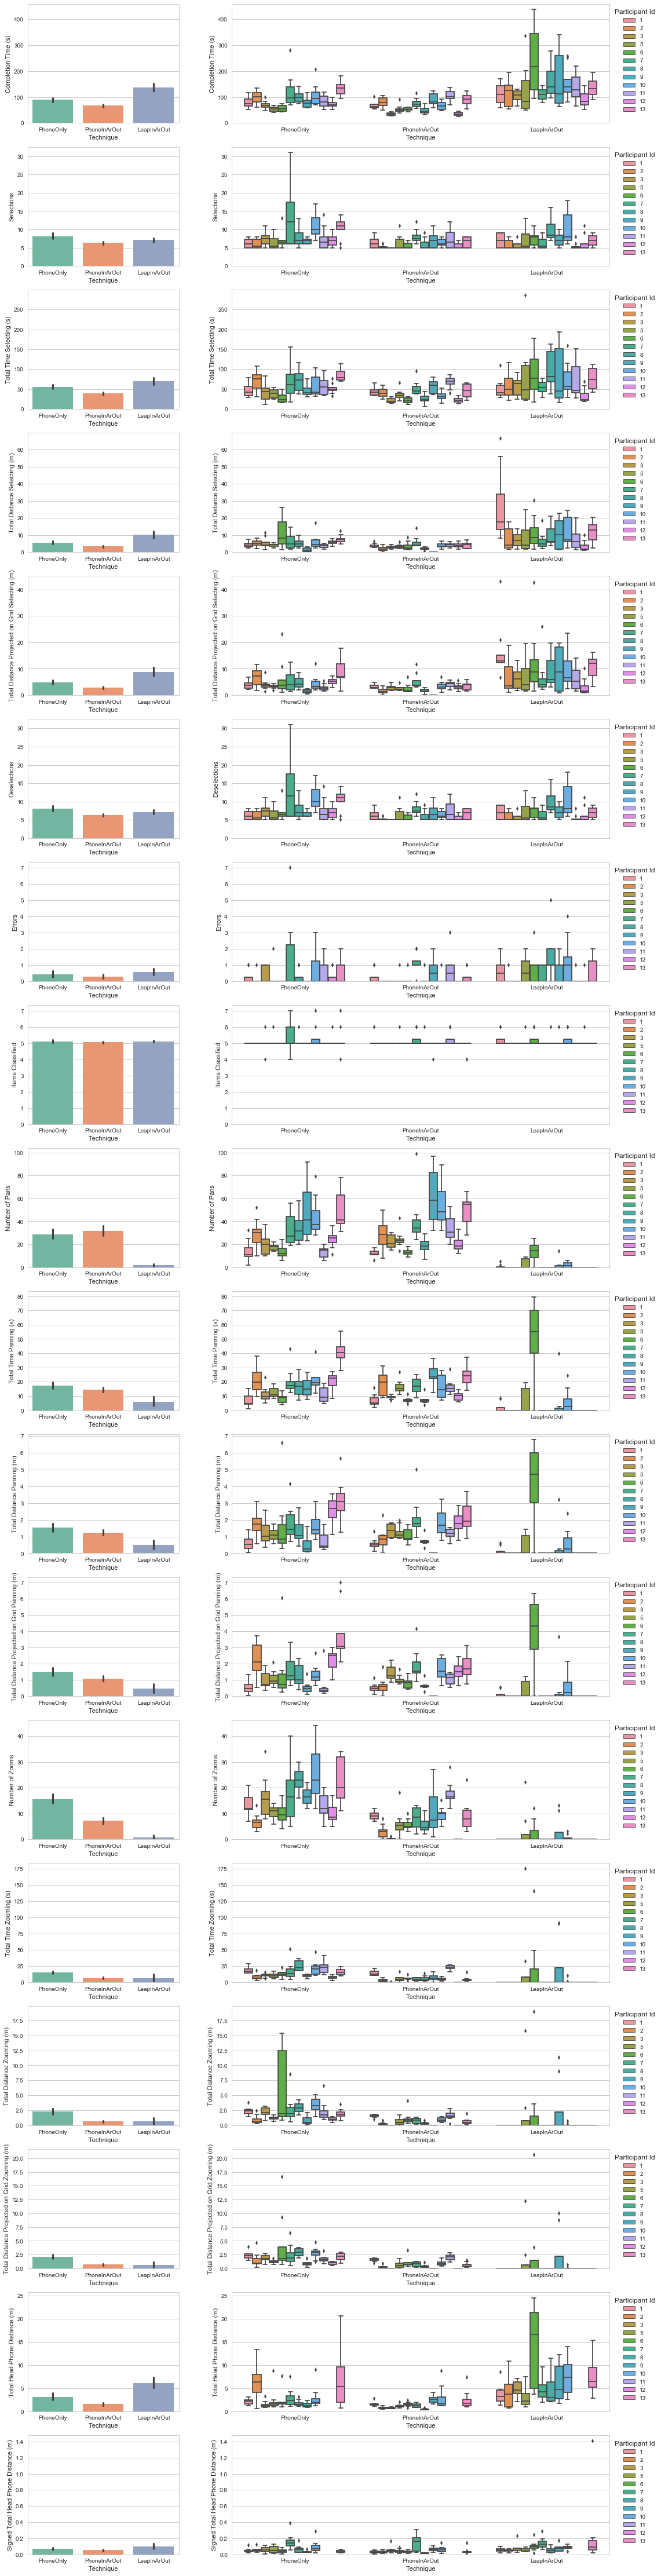

In [39]:
fig = plt.figure(figsize=(18, 4.5 * len(trials_dvs.columns)))
gs = gridspec.GridSpec(nrows=len(trials_dvs.columns), ncols=2, width_ratios=[1, 2.5])

for row in range(len(trials_dvs.columns)):
    iv, dv = trials_ivs['technique'], trials_dvs.iloc[:, row]
    
    ax1 = plt.subplot(gs[2 * row])
    sns.barplot(x=iv['label'], y=dv['label'], data=trials, palette=iv['palette'], ax=ax1)
    ax1.set(xlabel=iv['name'], ylabel=dv['name'], ylim=(0, None))

    ax2 = plt.subplot(gs[2 * row + 1], sharey=ax1)
    sns.boxplot(x=iv['label'], y=dv['label'], hue='participant_id', data=trials, ax=ax2)
    ax2.set(xlabel=iv['name'], ylabel=dv['name'], ylim=(0, None))
    ax2.legend(title=participants_ivs['participant_id']['name'], loc='upper left', bbox_to_anchor=(1, 1))

## Completion time

Visualize the mean times an errors for each IV and for some IVs combination:

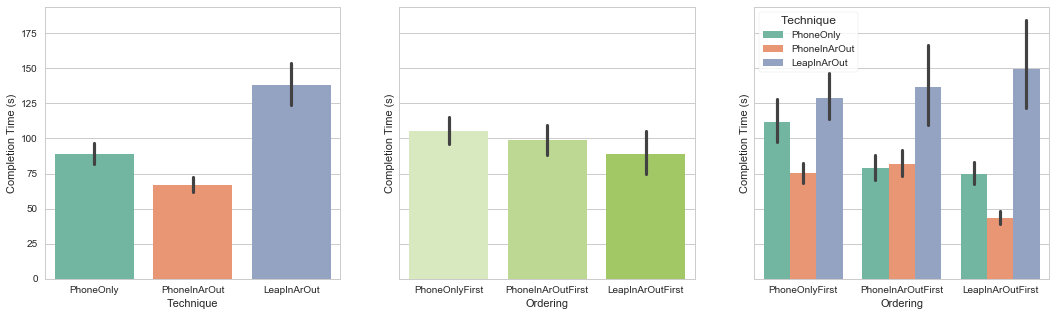

In [69]:
plot_trials([['technique'], ['ordering'], ['technique', 'ordering']], 'total_time')

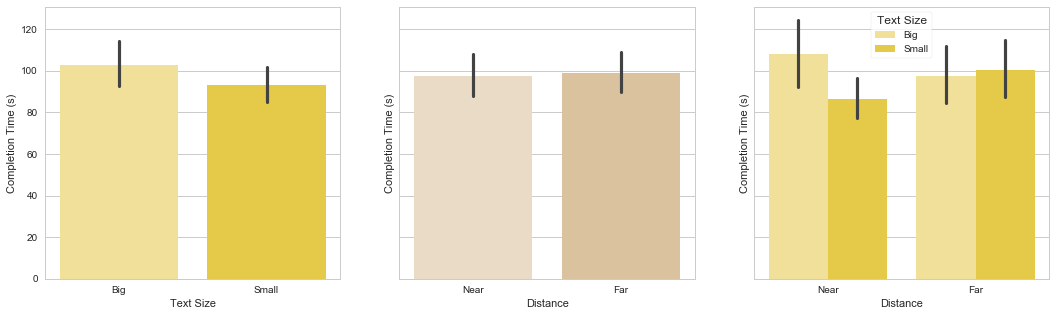

In [276]:
plot_trials([['text_size'], ['distance'], ['text_size', 'distance']], 'total_time')

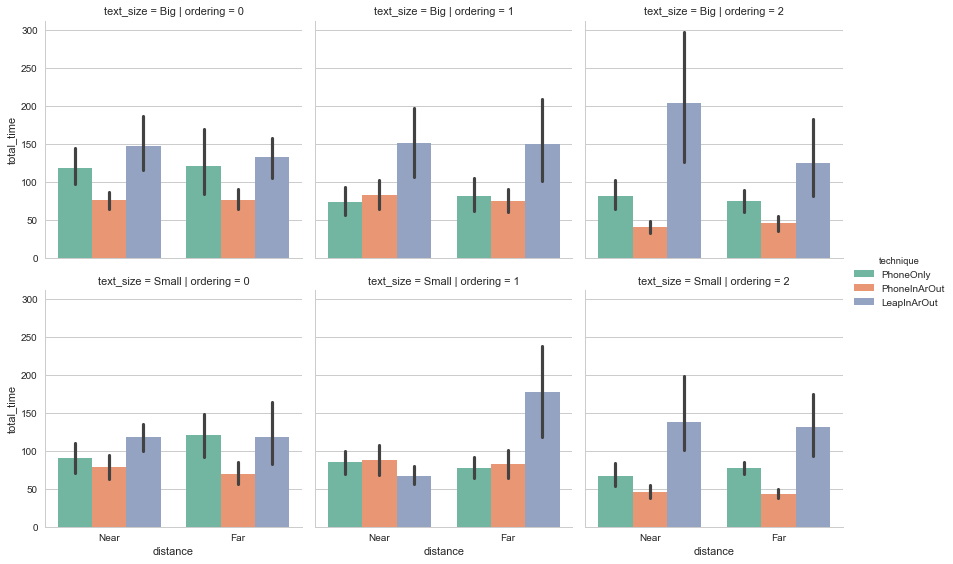

In [278]:
sns.factorplot(x='distance', y='total_time', col='ordering', row='text_size', hue='technique', data=trials, kind='bar', palette=trials_ivs['technique']['palette'])

Test the normality of the COMPLETION_TIME distributions for each condition with the Shapiro-Wilk test:

In [71]:
# TODO
for iv in trials_ivs.columns:
    for iv_category in trials_ivs[iv]['categorical']:
        print(iv_category)

PhoneOnly
PhoneInArOut
LeapInArOut
Big
Small
Near
Far
PhoneOnlyFirst
PhoneInArOutFirst
LeapInArOutFirst
Phone
MidAir
PhoneOnly
ExtendedPhone


Perform a full-factorial ANOVA for the model COMPLETION_TIME = TECHNIQUE x ORDERING x TEXT_SIZE x DISTANCE. Only the results with p-value < 0.05 are shown. The a main effects are TECHNIQUE and TECHNIQUE x ORDERING. The other effects are TECHNIQUE x ORDERING, TEXT_SIZE x DISTANCE, TECHNIQUE x ORDERING x DISTANCE, TECHNIQUE x TEXT_SIZE x DISTANCE with less effect size.

In [266]:
model = ols('total_time ~ technique * ordering * text_size * distance', data=trials).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table[anova_table['PR(>F)'] < 0.05]

,sum_sq,df,F,PR(>F)
technique,255841.806121,2.0,53.717004,3.599873e-20
technique:ordering,48542.997144,4.0,5.096087,5.771065e-04
text_size:distance,10652.186262,1.0,4.473104,3.541030e-02
technique:ordering:distance,30302.792639,4.0,3.181214,1.421481e-02
technique:text_size:distance,17198.665717,2.0,3.611063,2.842511e-02


Test the normality of the normality of the ANOVA's residuals with a quantile-quantile plot and the Shapiro-Wilk test. The s-curve in the Q-Q plot implies the distribution have a long tail, which seems to corresponds of the often very long first trials of the participants.

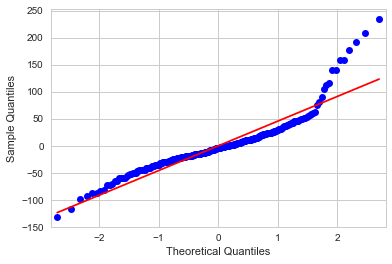

Shapiro-Wilk test on residuals: (W, p) = (0.8768350481987, 1.753115949393487e-14)


In [273]:
sm.qqplot(model.resid, line='s')
plt.show()

print("Shapiro-Wilk test on residuals: (W, p) = " + str(stats.shapiro(model.resid)))

*PhoneInArOut* is the fastest to complete and *LeapInArOut* the longest, like I hypothesised. TODO: t-test to confirm

## Errors

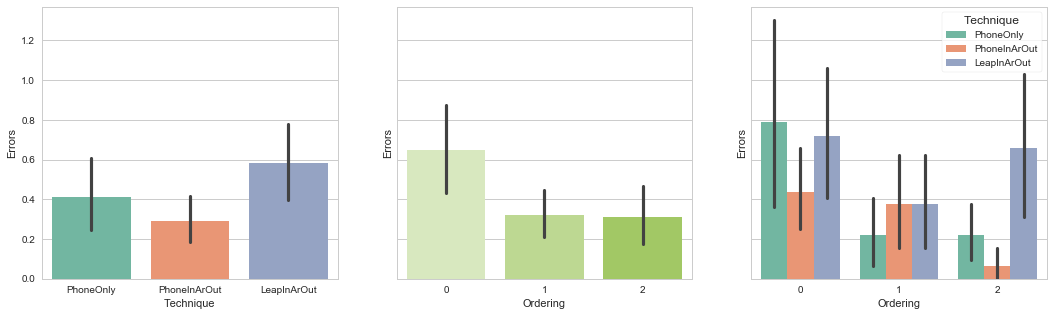

In [315]:
plot_trials([['technique'], ['ordering'], ['technique', 'ordering']], 'errors')

In [322]:
errors_model = ols('errors ~ technique * ordering * text_size * distance', data=trials).fit()
errors_anova = sm.stats.anova_lm(errors_model, typ=2)
errors_anova[errors_anova['PR(>F)'] < 0.05]

,sum_sq,df,F,PR(>F)
ordering,7.16669,2.0,5.022639,0.007259


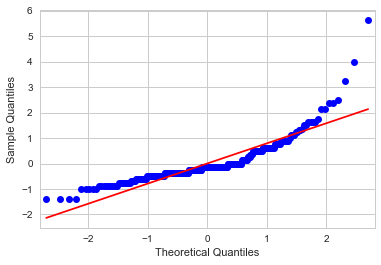

Shapiro-Wilk test on residuals: (W, p) = (0.8768350481987, 1.753115949393487e-14)


In [323]:
sm.qqplot(errors_model.resid, line='s')
plt.show()

print("Shapiro-Wilk test on residuals: (W, p) = " + str(stats.shapiro(model.resid)))

None of TECHNIQUE, DISTANCE or TEXT_SIZE have a significant effect on ERRORS. However ORDERING have an effect.

# Bonus

## Grid configuration

Visualize the distribution of the items to classify:

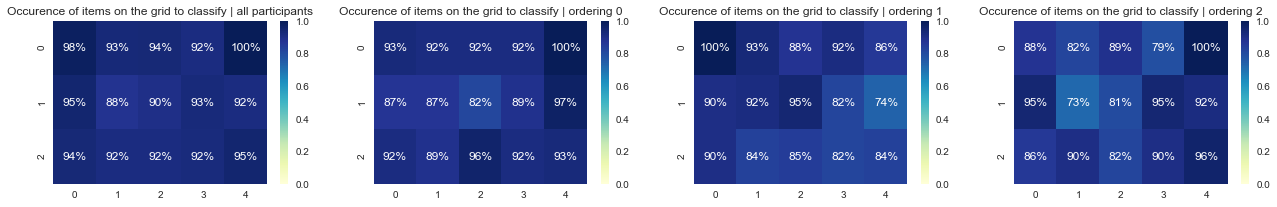

In [312]:
grid_shape, grid_items_count = (5, 3), 5

def count_grid_items_to_classify(participant_ids):
    grid_counts = pd.DataFrame(0, columns=range(grid_shape[0]), index=range(grid_shape[1]))
    for index, grid_config in trials.loc[trials['participant_id'].isin(participant_ids), 'grid_config'].iteritems():
        for i in range(grid_shape[1]):
            for j in range(grid_shape[0]):
                if grid_config[i][j][0] == grid_config[i][j][grid_items_count - 1]:
                    grid_counts.iat[i, j] = grid_counts.iat[i, j] + 1
    return grid_counts

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(22,3))

grid_counts = count_grid_items_to_classify(participants.index.tolist())
grid_counts = grid_counts / max(grid_counts.max())
sns.heatmap(grid_counts, vmin=0, annot=True, fmt='.0%', cmap='YlGnBu', ax=axs[0])
axs[0].set(title='Occurence of items on the grid to classify | all participants')

for i in range(len(ordering_categories)):
    grid_counts = count_grid_items_to_classify(participants[participants['ordering'] == ordering_categories[i]].index.tolist())
    grid_counts = grid_counts / max(grid_counts.max())
    sns.heatmap(grid_counts, vmin=0, annot=True, fmt='.0%', cmap='YlGnBu', ax=axs[i+1])
    axs[i+1].set(title='Occurence of items on the grid to classify | ordering ' + str(ordering_categories[i]))